In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
kaggleMoviesDataPath = '/kaggle/input/movie-recommendation-system-dataset/movies.csv'
moviesData = pd.read_csv(kaggleMoviesDataPath, encoding = 'utf-8').head(10000)
moviesData.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
print(moviesData.shape)

(10000, 3)


In [4]:
moviesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10000 non-null  int64 
 1   title    10000 non-null  object
 2   genres   10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [5]:
for col in moviesData.columns:
    print(f'*{col}* has *{moviesData[col].nunique()}* unique values and {moviesData[col].isnull().sum()} null values')

*movieId* has *10000* unique values and 0 null values
*title* has *9999* unique values and 0 null values
*genres* has *780* unique values and 0 null values


## 2. `Data Preprocessing/Cleaning`

In [6]:
moviesData['genres'][:5].values

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy'], dtype=object)

➡️ 'genres' column has genres divided by a '|', we need to change this.

In [7]:
moviesData['genres'] = moviesData['genres'].str.replace('|', ' ', regex=False)

In [10]:
moviesData[['genres']][:5]

,genres
0,Adventure Animation Children Comedy Fantasy
1,Adventure Children Fantasy
2,Comedy Romance
3,Comedy Drama Romance
4,Comedy


➡️ Its time to filter out any stopwords in the genres, because with this feature we are going to predict the movies best suitable for the user

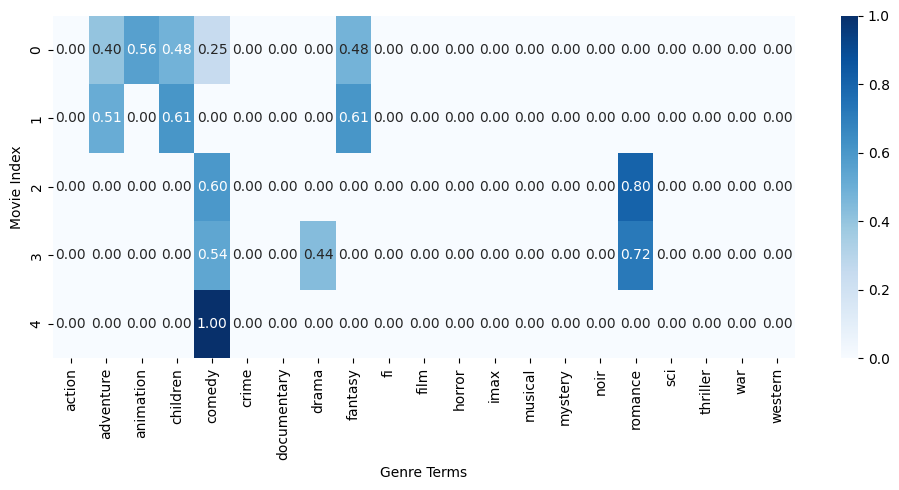

In [14]:
# with this we remove the stopwords.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(moviesData['genres'])

feature_names = tfidf.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix[:5].toarray(), columns=feature_names)

plt.figure(figsize = (10,5))
sns.heatmap(df_tfidf, annot = True, fmt=".2f", cmap='Blues')
plt.xlabel("Genre Terms")
plt.ylabel("Movie Index")
plt.tight_layout()
plt.show()

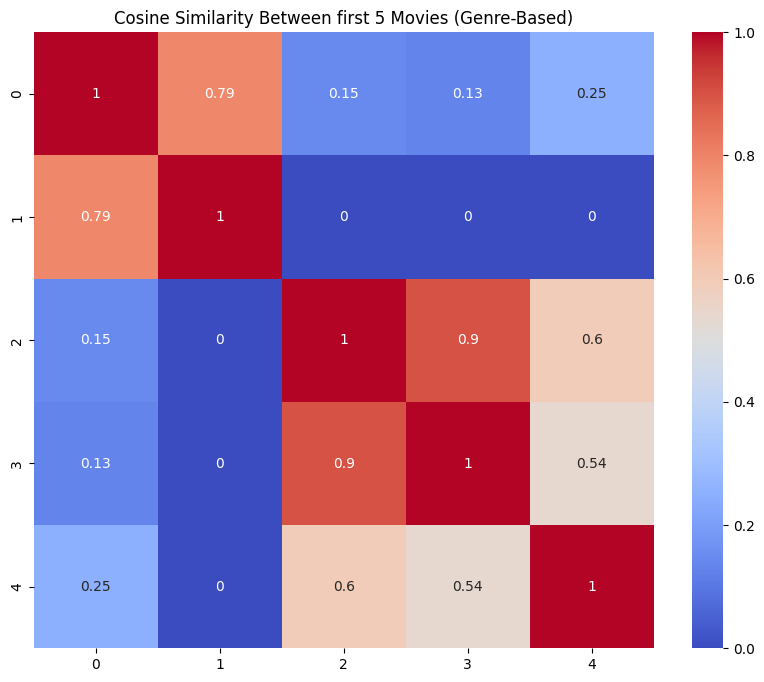

In [24]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim[:5, :5], cmap='coolwarm', annot = True)
plt.title("Cosine Similarity Between first 5 Movies (Genre-Based)")
plt.show()

In [28]:
indices = pd.Series(moviesData.index, index=moviesData['title']).drop_duplicates()
indices["Jumanji (1995)"]

1

In [39]:
# This functions returns the top 10 most similar movies to "title"
def recommend(title, n=10):
    try:
        if title not in indices.index:
            return f"❌ Movie '{title}' not found!"
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n+1]

        movie_indices = [i[0] for i in sim_scores]
        return moviesData['title'].iloc[movie_indices]
        
    except Exception as e:
        raise e

recommend('Jumanji (1995)')

59                     Indian in the Cupboard, The (1995)
124                     NeverEnding Story III, The (1994)
986                       Escape to Witch Mountain (1975)
1954            Darby O'Gill and the Little People (1959)
2003                                  Return to Oz (1985)
2071                        NeverEnding Story, The (1984)
2072    NeverEnding Story II: The Next Chapter, The (1...
2308                        Santa Claus: The Movie (1985)
4791    Harry Potter and the Sorcerer's Stone (a.k.a. ...
9559                            Magic in the Water (1995)
Name: title, dtype: object